In [2]:
# importing libraries 
import numpy as np
from uncertainties import ufloat
import matplotlib.pyplot as plt

# standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.opflow.primitive_ops import PauliSumOp
from qiskit.providers.aer import AerSimulator
from qiskit.opflow import Z,I,X
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import SPSA,  COBYLA
from qiskit.providers.basicaer import QasmSimulatorPy  # local simulator 
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit.algorithms.minimum_eigensolvers import VQE
import matplotlib.pyplot as plt

# noise model object
from qiskit.providers.aer.noise import NoiseModel
# standard errors
from qiskit.providers.aer.noise.errors import *  
# noise base classes
from qiskit.providers.aer.noise.errors.quantum_error import QuantumError
# NECESSARY LIBRARIES FOR PRIMITIVES 
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session, Options

### FUNCTIONS DEFINITION

In [2]:
def ham_generator(N,h,J):
    H=0
    
    # field term
    for i in range (N):
        H+= h*((I^(i))^(Z)^(I^(N-i-1))) 
    # interaction term
    for k in range(N-1):
        H+= J*((I^(k))^(X^X)^(I^(N-k-2)))
    # PBC
    H+= J*((X)^(I^(N-2))^(X))           
    return H    

#function that calculates the forward derivative
def f_derivative(a,b,en,npoints):

    step = (b-a)/(npoints-1)
    for i in range(npoints):
        if a + i*step == 0:
            print('zero found in position >>', i)
            z=i
            break
    fd = (en[z+1]-en[z])/(step)
    
    print('spacing used to calculate the derivative >> ', step)
    print('numerical derivative of E(h), h->0+ >>', fd)
    return fd


#function that calculates the backward derivative
def b_derivative(a,b,en,npoints):

    step = (b-a)/(npoints-1) 
    for i in range(npoints):
        if a + i*step == 0:
            print('zero found in position >>', i)
            z=i
            break
    bd = (en[z]-en[z-1])/(step)
    
    print('spacing used to calculate the derivative >> ', step)
    print('numerical derivative of E(h), h->0- >>', bd)
    return bd

## NOISELESS SIMULATIONS for N=5 and N=6 qubits

In [3]:
#parameters definition: number of spins, field and interaction term
nqubits=5
J=1.
h=np.linspace(-0.4,0.4,3)
energy_5=np.zeros(np.size(h))

service = QiskitRuntimeService()
backend = "ibmq_qasm_simulator"

ansatz = EfficientSU2(nqubits, reps=3, entanglement='linear', insert_barriers=True)

optimizer = SPSA(maxiter=500)

initial_point = np.random.random(ansatz.num_parameters)

# Create an object to store intermediate results
from dataclasses import dataclass
@dataclass
class VQELog:
    values: list
    parameters: list
    def update(self, count, parameters, mean, _metadata):
        self.values.append(mean)
        self.parameters.append(parameters)
        print(f"Running circuit {count} of ~400", end="\r", flush=True)

log = VQELog([],[])

In [30]:
# Main calculation - RESULTS FOR 500 SPSA ITER
with Session(service=service, backend=backend) as session:
    options = Options()
    options.optimization_level = 3

    for i in range(np.size(h)):
        log = VQELog([],[])
        vqe = VQE(Estimator(session=session, options=options),
                  ansatz, optimizer, callback=log.update, initial_point=initial_point)
    
        H = ham_generator(nqubits,h[i],J)
        result = vqe.compute_minimum_eigenvalue(H)
        energy_5[i]=result.optimal_value
        print("Experiment complete.".ljust(30))
        print(f"Raw result: {result.optimal_value}")
        #print(log.values)
        

    if 'simulator' not in backend:
        # Run once with ZNE error mitigation
        options.resilience_level = 2
        vqe = VQE(Estimator(session=session, options=options),
                  ansatz, SPSA(1), initial_point=result.optimal_point)
        result = vqe.compute_minimum_eigenvalue(H)
        print(f"Mitigated result: {result.optimal_value}")

Experiment complete.          
Raw result: -3.7874
Experiment complete.          
Raw result: -2.9880000000000004
Experiment complete.          
Raw result: -3.7592


zero found in position >> 1
spacing used to calculate the derivative >>  0.4
numerical derivative of E(h), h->0+ >> -1.9479999999999897
zero found in position >> 1
spacing used to calculate the derivative >>  0.4
numerical derivative of E(h), h->0- >> 2.0184999999999897
-3.9664999999999795


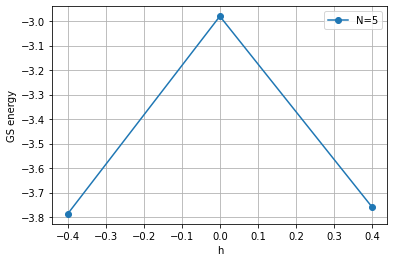

In [39]:
print(f_derivative(-0.4,0.4,energy_5,3)-b_derivative(-0.4,0.4,energy_5,3))
h =[-0.4,0,0.4]
energy_5=[-3.7874,-2.980000000000004,-3.7592]
plt.grid()
plt.xlabel('h')
plt.ylabel('GS energy')
plt.plot(h,energy_5,marker='o',label='N=5')
plt.legend()
plt.show()

In [15]:
nqubits=6
J=1.
h = np.linspace(-0.4,0.4,3)
energy_6=np.zeros(np.size(h))
print(h)

[-0.4  0.   0.4]


In [16]:
service = QiskitRuntimeService()
backend = "ibmq_qasm_simulator"
ansatz = EfficientSU2(nqubits, reps=3, entanglement='linear', insert_barriers=False)
initial_point = np.random.random(ansatz.num_parameters)
optimizer = SPSA(maxiter=500)
log = VQELog([],[])

In [17]:
# Main calculation
with Session(service=service, backend=backend) as session:
    options = Options()
    options.optimization_level = 3

    for i in range(np.size(h)):
        log = VQELog([],[])
        vqe = VQE(Estimator(session=session, options=options),
                  ansatz, optimizer, callback=log.update, initial_point=initial_point)
    
        H = ham_generator(nqubits,h[i],J)
        result = vqe.compute_minimum_eigenvalue(H)
        energy_6[i]=result.optimal_value
        print("Experiment complete.".ljust(30))
        print(f"Raw result: {result.optimal_value}")
        #print(log.values)
        

    if 'simulator' not in backend:
        # Run once with ZNE error mitigation
        options.resilience_level = 2
        vqe = VQE(Estimator(session=session, options=options),
                  ansatz, SPSA(1), initial_point=result.optimal_point)
        result = vqe.compute_minimum_eigenvalue(H)
        print(f"Mitigated result: {result.optimal_value}")

Experiment complete.          
Raw result: -6.216399999999999
Experiment complete.          
Raw result: -5.9935
Experiment complete.          
Raw result: -6.0508


zero found in position >> 1
spacing used to calculate the derivative >>  0.4
numerical derivative of E(h), h->0+ >> -0.1432499999999992
zero found in position >> 1
spacing used to calculate the derivative >>  0.4
numerical derivative of E(h), h->0- >> 0.557249999999998
-0.7004999999999972


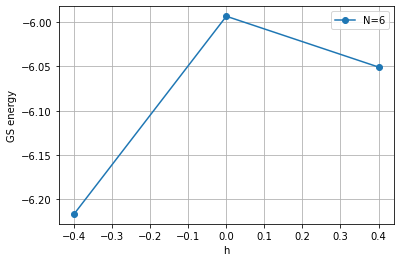

In [42]:
print(f_derivative(-0.4,0.4,energy_6,3)-b_derivative(-0.4,0.4,energy_6,3))
energy_6 = [-6.216399999999999,-5.9935,-6.0508]
h =[-0.4,0,0.4]
plt.grid()
plt.xlabel('h')
plt.ylabel('GS energy')
plt.plot(h,energy_6,marker='o',label='N=6')
plt.legend()
plt.show()

In [23]:
# noiseless energies
energy_6 = [-6.216399999999999,-5.9935,-6.0508]
energy_5=[-3.7874,-2.980000000000004,-3.7592]

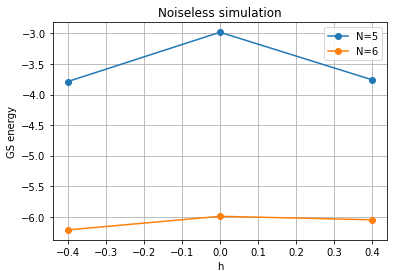

In [24]:
h =[-0.4,0,0.4]
plt.grid()
#plt.ylim(-7,2)
plt.title('Noiseless simulation')
plt.xlabel('h')
plt.ylabel('GS energy')
plt.plot(h,energy_5,marker='o',label='N=5')
plt.plot(h,energy_6,marker='o',label='N=6')
plt.legend()
plt.show()

## NOISY SIMULATIONS WITH FAKE PROVIDER

In [5]:
# importing libraries
from qiskit.providers.fake_provider import FakeGeneva, FakeVigo, FakeNairobi
from qiskit_aer.noise import NoiseModel

In [5]:
#parameters definition: number of spins, field and interaction term
nqubits=5
J=1.
h=np.linspace(-0.4,0.4,3)
energy_5=np.zeros(np.size(h))

In [14]:
service = QiskitRuntimeService()
ansatz = EfficientSU2(nqubits, reps=3, entanglement='linear', insert_barriers=True)
optimizer = SPSA(maxiter=500)
initial_point = np.random.random(ansatz.num_parameters)

In [15]:
backend = service.get_backend('ibm_nairobi')
backend_noise_model = NoiseModel.from_backend(backend)
simulator = service.get_backend('ibmq_qasm_simulator')

options = Options()
options.optimization_level = 3
options.simulator = {
"noise_model": backend_noise_model
}

/opt/conda/lib/python3.8/site-packages/qiskit_aer/noise/device/models.py:145: UserWarning: When `target` is supplied, `standard_gates` and `warnings` are ignored, and they are always set to true.
  warn("When `target` is supplied, `standard_gates` and `warnings` are ignored,"
/opt/conda/lib/python3.8/site-packages/qiskit_aer/noise/device/models.py:365: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (0.00015668723661479977 > 2 * 6.940155061593941e-05). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/opt/conda/lib/python3.8/site-packages/qiskit_aer/noise/device/models.py:365: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (0.00015668723661479977 > 2 * 6.940155061593941e-05). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"


In [9]:
# Main calculation - RESULTS FOR 500 SPSA ITER
with Session(service=service, backend=simulator) as session:

    for i in range(np.size(h)):
        log = VQELog([],[])
        
        vqe = VQE(Estimator(session=session, options=options),
                  ansatz, optimizer, callback=log.update, initial_point=initial_point)
    
        H = ham_generator(nqubits,h[i],J)
        result = vqe.compute_minimum_eigenvalue(H)
        energy_5[i]=result.optimal_value
        print("Experiment complete.".ljust(30))
        print(f"Raw result: {result.optimal_value}")
        #print(log.values)
        

        #if 'simulator' not in backend:
        # Run once with ZNE error mitigation
        #    options.resilience_level = 2
        #    vqe = VQE(Estimator(session=session, options=options),
        #          ansatz, SPSA(1), initial_point=result.optimal_point)
        #    result = vqe.compute_minimum_eigenvalue(H)
        #    print(f"Mitigated result: {result.optimal_value}")

Experiment complete.          
Raw result: -3.6701492846740025
Experiment complete.          
Raw result: -2.8721001305384037
Experiment complete.          
Raw result: -3.5730851889644457


zero found in position >> 1
spacing used to calculate the derivative >>  0.4
numerical derivative of E(h), h->0+ >> -1.752462646065105
zero found in position >> 1
spacing used to calculate the derivative >>  0.4
numerical derivative of E(h), h->0- >> 1.9951228853389968
-3.747585531404102


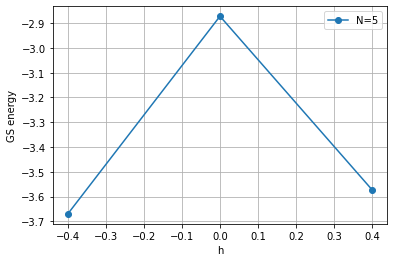

In [19]:
energy_5=[-3.6701492846740025,-2.8721001305384037,-3.5730851889644457]
print(f_derivative(-0.4,0.4,energy_5,3)-b_derivative(-0.4,0.4,energy_5,3))
h =[-0.4,0,0.4]
plt.grid()
plt.xlabel('h')
plt.ylabel('GS energy')
plt.plot(h,energy_5,marker='o',label='N=5')
plt.legend()
plt.show()

In [16]:
nqubits=6
J=1.
h=np.linspace(-0.4,0.4,3)
energy_6=np.zeros(np.size(h))
ansatz = EfficientSU2(nqubits, reps=3, entanglement='linear', insert_barriers=True)
optimizer = SPSA(maxiter=500)
initial_point = np.random.random(ansatz.num_parameters)

In [18]:
# Main calculation - RESULTS FOR 500 SPSA ITER
with Session(service=service, backend=simulator) as session:

    for i in range(np.size(h)):
        log = VQELog([],[])
        
        vqe = VQE(Estimator(session=session, options=options),
                  ansatz, optimizer, callback=log.update, initial_point=initial_point)
    
        H = ham_generator(nqubits,h[i],J)
        result = vqe.compute_minimum_eigenvalue(H)
        energy_6[i]=result.optimal_value
        print("Experiment complete.".ljust(30))
        print(f"Raw result: {result.optimal_value}")
        #print(log.values)
        

        #if 'simulator' not in backend:
        # Run once with ZNE error mitigation
        #    options.resilience_level = 2
        #    vqe = VQE(Estimator(session=session, options=options),
        #          ansatz, SPSA(1), initial_point=result.optimal_point)
        #    result = vqe.compute_minimum_eigenvalue(H)
        #    print(f"Mitigated result: {result.optimal_value}")

Experiment complete.          
Raw result: -5.650883729926863
Experiment complete.          
Raw result: -5.459984851301243
Experiment complete.          
Raw result: -5.521632275403579


zero found in position >> 1
spacing used to calculate the derivative >>  0.4
numerical derivative of E(h), h->0+ >> -0.15411856025584036
zero found in position >> 1
spacing used to calculate the derivative >>  0.4
numerical derivative of E(h), h->0- >> 0.4772471965640501
-0.6313657568198905


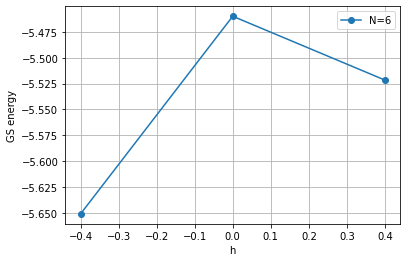

In [20]:
print(f_derivative(-0.4,0.4,energy_6,3)-b_derivative(-0.4,0.4,energy_6,3))
h =[-0.4,0,0.4]
plt.grid()
plt.xlabel('h')
plt.ylabel('GS energy')
plt.plot(h,energy_6,marker='o',label='N=6')
plt.legend()
plt.show()

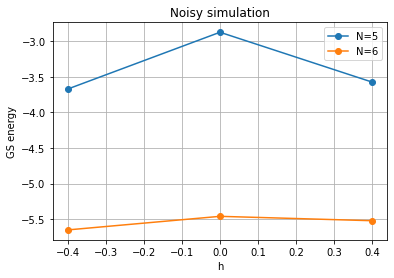

In [22]:
h =[-0.4,0,0.4]
plt.grid()
#plt.ylim(-7,2)
plt.title('Noisy simulation')
plt.xlabel('h')
plt.ylabel('GS energy')
plt.plot(h,energy_5,marker='o',label='N=5')
plt.plot(h,energy_6,marker='o',label='N=6')
plt.legend()
plt.show()

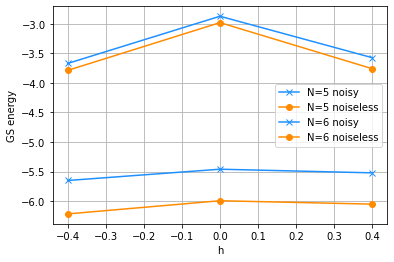

In [37]:
# noiseless energies
energy_6nl = [-6.216399999999999,-5.9935,-6.0508]
energy_5nl=[-3.7874,-2.980000000000004,-3.7592]

#noisy energies
energy_6n =[-5.650883729926863,-5.459984851301243,-5.521632275403579]
energy_5n = [-3.6701492846740025,-2.8721001305384037,-3.5730851889644457]

plt.xlabel('h')
plt.ylabel('GS energy')
plt.grid()
plt.plot(h,energy_5n,color='dodgerblue',marker='x',label='N=5 noisy')
plt.plot(h,energy_5nl,color='darkorange',marker='o',label='N=5 noiseless')
plt.plot(h,energy_6n,color='dodgerblue',marker='x',label='N=6 noisy')
plt.plot(h,energy_6nl,color='darkorange',marker='o',label='N=6 noiseless')


plt.legend()
plt.show()

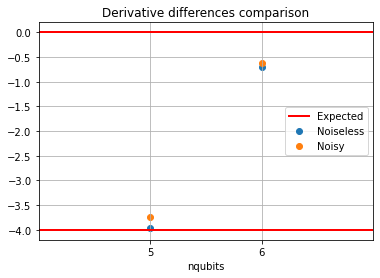

In [47]:
# noiseless derivative differences
d_nl = [-3.9664999999999795,-0.7004999999999972]

#noisy derivative differences
d_n =[-3.747585531404102,-0.6313657568198905]

index = [5,6]
plt.xticks(index)
plt.xlim(4,7)
plt.xlabel('nqubits')
plt.title('Derivative differences comparison')
plt.axhline(y=0,color='red',linewidth=2,label='Expected')
plt.axhline(y=-4,color='red',linewidth=2)
plt.scatter(index,d_nl,label='Noiseless')
plt.scatter(index,d_n,label='Noisy')
plt.legend()
plt.grid()

## VQD

In [7]:
nqubits=5
J=1.
h=0.2
vqd_values=[]
from qiskit.algorithms.eigensolvers import VQD
from qiskit.primitives import Sampler
from qiskit.algorithms.state_fidelities import ComputeUncompute,BaseStateFidelity
from qiskit.algorithms.optimizers import SLSQP, SPSA
from qiskit.algorithms.eigensolvers import NumPyEigensolver
from qiskit.quantum_info import SparsePauliOp
from qiskit.opflow import PauliSumOp

In [8]:

def ham5_generator(h,J):
    H = SparsePauliOp.from_list(
        [
            ("ZIIII", h),
            ("IZIII", h),
            ("IIZII", h),
            ("IIIZI", h),
            ("IIIIZ", h),
            ("XXIII", J),
            ("IXXII", J),
            ("IIXXI", J),
            ("IIIXX", J),
            ("XIIIX", J),
        ]
    )
    return H

In [14]:
service = QiskitRuntimeService()

backend = "ibmq_qasm_simulator"
ansatz = EfficientSU2(nqubits, reps=3, entanglement='linear', insert_barriers=False)
initial_point = np.random.random(ansatz.num_parameters)
#optimizer = SLSQP(maxiter=50,disp=True,max_evals_grouped=1)
#optimizer = SPSA(maxiter=1)
optimizer = SLSQP(maxiter=50,disp=True)

In [15]:
betas=[33,33]

with Session(service=service, backend=backend) as session:
    options = Options()
    options.optimization_level = 2
    sampler = Sampler()
    options.resilience_level = 2
    H = ham_generator(5,0.2,1.)
    
    vqd = VQD(estimator = Estimator(session=session,options = options),fidelity =ComputeUncompute(sampler) ,
            ansatz=ansatz, optimizer=optimizer, k=2,betas=betas,initial_point=initial_point)
    
    result = vqd.compute_eigenvalues(operator = H)
    
    vqd_values.append(result.optimal_values)
    print(result.optimal_values)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.08565833333333336
            Iterations: 8
            Function evaluations: 194
            Gradient evaluations: 4


/opt/conda/lib/python3.8/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Optimization terminated successfully    (Exit mode 0)
            Current function value: 32.86628948403513
            Iterations: 9
            Function evaluations: 245
            Gradient evaluations: 5
[-0.08565833 32.86628948]
